<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C2-Sequence1/sequences/draft_sequences/GP_andMDP_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is some rough work on Gaussian Processes and MDP notation

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab
!pip install pyDOE GPy gpyopt


import requests
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import GPy
import GPyOpt
from copy import copy
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S1"




###########################################################
# new definition gridworld board to support multiple agents
###########################################################









################################################################
# refactor Monte Carlo for boards that support multiple critters
################################################################




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def pis_vs_from_board(self, board, critter):
    #helper function, to put board in canonical form that nn was trained on
    batch_size, n_rows, n_cols = board['pieces'].shape
    co_pieces = board['pieces'].copy()
    this_critter_locs = np.where(co_pieces == critter)
    all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    co_pieces[this_critter_locs] = 1
    scalar_rounds_left = board['rounds_left'][0]
    co_rounds_left = scalar_rounds_left // self.game.num_critters
    if critter-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
       co_rounds_left = co_rounds_left + 1
    co_rounds_left = np.array([co_rounds_left]*batch_size)
    pis, vs = self.nnet.predict(co_pieces,
                                board['scores'][:,critter-1],
                                co_rounds_left)
    return pis, vs


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes)
    # in this version of the mc player, the existence of other players is
    # ignored, in another version of mc other players moves might be simulated
    next_board['active_player'] = critter-1

    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'][:,critter-1].copy()
        return terminal_vs
      else:
        #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        pis, vs = self.pis_vs_from_board(next_board, critter)
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)
      # in this version of the mc player, existence of other players is ignored
      # in another better version other players moves might be simulated, either
      # as copies of self, or as distinct environmental dynamics
      next_board['active_player'] = critter-1


    pis, vs = self.pis_vs_from_board(next_board, critter)
    #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
    #                            next_board['rounds_left'])
    #print(vs.shape)
    return vs

Random seed 2021 has been set.
Running in colab


In [2]:
# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles

def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]]) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=250, marker=spec['marker'],
                           color=spec['color'], label=spec['name'])
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()

In [3]:
# @title GridworldBoard class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  active_player keeps track of which players turn it is

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng = None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_critters = num_critters
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime * self.num_critters)
    # each players move counts down the clock so making this a multiple of the
    # number of critters ensures every player gets an equal number of turns
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][self.num_critters:],
                   rc_idx[1][self.num_critters:])] = -1
    self.active_player = 0
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
      active_player: int
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.active_player = copy(board['active_player'])


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves, critter):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord.

    Notes:
      Assumes that there is exactly one valid move for each board in the
      batch of boards for the critter type given. i.e. it does't check for
      bounce/reflection on edges or with other critters, or for multiple move
      made on the same board. It only checks for eating food and adds new food
      when appropriate. Invalid moves could lead to illegal teleporting
      behavior, critter duplication, or index out of range errors.

      Currently just prints a message if critter making the move is not the
      active player, could enforce this more strictly if needed.
    """
    if critter-1 != self.active_player:
      # note critter is [1 to num_critter] inclusive so that it can be used
      # directly in where statements on pieces but self.active_player is
      # [0 to numcritter-1] inclusive so that it can be used directly in
      # indexing player lists
      raise ValueError("Warning! The critter moving is not the expected active player")
    #critters leave their spots
    self.pieces[self.pieces==critter] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    # note critter is +int so need to -1 for indexing
    self.scores[:,critter-1] = self.scores[:,critter-1] + eats_food

    num_empty_after_eat = (self.n_rows*self.n_cols - self.num_food -
                           self.num_critters + 1) # +1 for the food just eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    # put critters in new positions
    self.pieces[moves] = critter
    if np.any(eats_food):
      # add random food to replace what is eaten
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = self.rng.choice(num_empty_after_eat,
                                     size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    self.rounds_left = self.rounds_left - 1
    if not np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1))):
      print(self.pieces.sum(axis=(1,2)))
      print(((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    assert np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    # next player's turn
    self.active_player = (self.active_player + 1) % (self.num_critters)


  def get_legal_moves(self, critter):
    """
    Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    # can only move one cell down, up, right, and left from current location
    critter_locs = np.array(np.where(self.pieces == critter))
    legal_offsets = np.stack([
      critter_locs + np.array([np.array([0,  1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, -1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0,  1])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0, -1])]*self.batch_size).T])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))
    legal_offsets = set([tuple(m_) for m_ in legal_offsets])
    # must land on the board and not on another critter
    legal_destinations = np.where(self.pieces <= 0)
    legal_destinations = set([(g, r, c) for
                              g, r, c in zip(*legal_destinations)])
    # legal moves satisfy both these conditions
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, radius, critter):
    """
    Generates a vector representation of the critter perceptions, oriented
    around the critter.

    Args:
      radius: int, how many grid squared the critter can see around it
        using L1  (Manhattan/cityblock) distance

    Returns:
      A batch_size x 2*radius*(radius+1) + 1, giving the values
      of the percept reading left to right, top to bottom over the board,
      for each board in the batch
    """
    # define the L1 ball mask
    diameter = radius*2+1
    mask = np.zeros((diameter, diameter), dtype=bool)
    mask_coords = np.array([(i-radius, j-radius)
      for i in range(diameter)
        for j in range(diameter)])
    mask_distances = cdist(mask_coords, [[0, 0]],
                           'cityblock').reshape(mask.shape)
    mask[mask_distances <= radius] = True
    mask[radius,radius] = False  # exclude the center

    # pad the array
    padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
     (radius, radius)), constant_values=-2)

    # get locations of critters
    critter_locs = np.argwhere(padded_arr == critter)

    percepts = []
    for critter_loc in critter_locs:
      b, r, c = critter_loc
      surrounding = padded_arr[b, r-radius:r+radius+1, c-radius:c+radius+1]
      percept = surrounding[mask]
      percepts.append(percept)
    return(np.array(percepts))

In [4]:
# @title GridworldGame class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################



class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng=None):
    """
    Initializes an instance of the class with the specified parameters.

    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_critters (int, optional): Number of different agents running around
        on each board in the batch. Default is 2.
      num_food (int, optional): Number of food items. Default is 10.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_critters, num_food,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_critters = num_critters
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 radius=2, figsize=(6,5), title=None,
                 name='Critter'):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # will need to think about how to do this for multiple
      # critters, currently just use rc of first critter in the spec list
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov)
      else:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov, fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_valid_actions(self, board, critter):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter)
    valids = np.zeros((batch_size, n_rows * n_cols))
    for g, r, c in legal_moves:
      valids[g, r * n_cols + c] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = self.actions_to_moves(actions)
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_critters=self.num_critters,
                         num_food=self.num_food, lifetime=self.lifetime,
                         rng=self.rng)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs, critter):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': np.array((0, -1, 0)),
        'down': np.array((0, 1, 0)),
        'left': np.array((0, 0, -1)),
        'right': np.array((0, 0, 1))}
    critter_locs = np.where(board['pieces'] == critter)
    probs_arrays = np.zeros((batch_size, n_rows * n_cols))
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = offset_dict[direction]
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays[batch_index, :] = prob_array
    return list(probs_arrays)


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'
    """
    offset_dict = {(0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = np.column_stack(np.where(board['pieces'] == critter))
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = critter_locs[critter_locs[:, 0] == g, 1:]
      # critter_loc shape is (1, 2)
      critter_loc = np.squeeze(critter_loc)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpyp array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state


  def play_game(self, players=[], collect_fov_data=False, fov_radius=2,
                visualize = False):
    """This method takes a list of players the same length as num_critters,
        and then plays a batch of games with them and returns the final board
        state"""
    if len(players) != self.num_critters:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    if collect_fov_data is True:
      batch_size, n_rows, n_cols = board['pieces'].shape
      b = GridworldBoard(batch_size=batch_size,
                         n_rows=n_rows, n_cols=n_cols,
                         num_critters=self.num_critters,
                         num_food=self.gwg.num_food,
                         lifetime=self.gwg.lifetime,
                         rng=self.gwg.rng)


    for ii in range(self.lifetime):
      for jj, player in enumerate(players):
        active_player_index = board['active_player']
        old_scores = board['scores']
        if collect_fov_data is True:
          b.set_state(board)
          percepts = b.get_perceptions(fov_radius)

        a_player, _, _ = players[active_player_index].play(board)
        board = self.get_next_state(board, active_player_index+1, a_player)
        if visualize == True:
          self.display(board, 0)
    return board



In [5]:
# @title player zoo
###########################################################################
# make a separate player zoo
###########################################################################




class RandomValidPlayer():
  """
  Instantiate random player for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or cornor or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs,
                                                    self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    #co_pieces = board['pieces'].copy()
    #this_critter_locs = np.where(co_pieces == self.critter_index+1)
    #all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    #co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    #co_pieces[this_critter_locs] = 1
    #scalar_rounds_left = board['rounds_left'][0]
    #co_rounds_left = scalar_rounds_left // self.game.num_critters
    #if self.critter_index-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
    #   co_rounds_left = co_rounds_left + 1
    #co_rounds_left = np.array([co_rounds_left]*batch_size)
    #pis, vs = self.nnet.predict(co_pieces,
    #                            board['scores'][:,self.critter_index-1],
    #                            co_rounds_left)
    pis, vs = self.mc.pis_vs_from_board(board, self.critter_index)
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Player based on the following simple policy:
  If there is any food immediately nearby move towards it,
  otherwise it move randomly.
  """

  def __init__(self, game, fov_radius=2, critter_index=1):
    """

    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 12 if fov_radius = 2)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -2 (out-of-bounds), 0 (empty space), or
        -1 (food).

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] == -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                direction_probs,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, valid_directions, W,
                                softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      direction_probs: dictionary with probabilities of taking each action.
    """
    if len(valid_directions) == 0:
      # if there is no where legit to move, stay put
      return 'still', {direction: 0 for direction in output_struct}

    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    x = np.asarray(percept == -1, int)
    output_activations = W @ x

    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    # set invalid direction activations to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in valid_directions]
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    # set invalid direction probabilities to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in invalid_directions]
    sm[invalid_indices] = 0
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
    direction = self.game.rng.choice(output_struct, p=probs_sm)
    direction_probs = {direction: prob
                        for direction, prob in zip(output_struct, probs_sm)}
    return direction, direction_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []

    # Get valid actions for each game in the batch
    valid_directions = self.game.get_valid_directions(board, self.critter_index)
    for g in range(batch_size):
      direction, batch_direction_probs = self.param_action_from_percept(
        perceptions[g], valid_directions[g], self.W, softmax_temp=temp)
      critter_oriented_moves.append(direction)
      direction_probs.append(batch_direction_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class BatchOptPerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter percieves, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specfic to this kind of critter
    self.deterministic = deterministic
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by 1D len 12 array representing the perceptions of the
      organism. Indices correspond to spaces around the organism. The values in
      the array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction_probs: array of probabilities of taking each action.
    """
    # a human interpretable overview of the percept structure
    #percept_struct = [
    #  'far up', 'left up', 'near up', 'right up',
    #  'far left', 'near left', 'near right', 'far right',
    #  'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    #output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    # x is batch x 12
    x = np.asarray(percepts == -1, int)
    # W is 4 x 12
    # this does the broadcasting we want
    output_activations = (W @ x.T).T
    # output activations is batch by 4
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    # note the fragile order based dependency on how legal offsets is written,
    # and how output activations are interpreted
    direction_v = self.direction_value_from_percept(perceptions, W)
    flat_ds = direction_v.T.ravel()

    critter_locs = np.array(np.where(board['pieces'] == self.critter_index))
    legal_offsets = np.stack([
    critter_locs + np.array([np.array([0, -1,  0])]*batch_size).T, # up
    critter_locs + np.array([np.array([0,  1,  0])]*batch_size).T, # down
    critter_locs + np.array([np.array([0,  0, -1])]*batch_size).T, # left
    critter_locs + np.array([np.array([0,  0,  1])]*batch_size).T]) #right
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))

    # conditions for offsets on the board
    c1 = legal_offsets[:,1] >= 0
    c2 = legal_offsets[:,1] <= n_rows-1
    c3 = legal_offsets[:,2] >= 0
    c4 = legal_offsets[:,2] <= n_cols-1
    all_c = np.logical_and.reduce([c1, c2, c3, c4])

    batch_indexes = legal_offsets[:,0][all_c]
    action_indexes = legal_offsets[:,1][all_c] * n_cols + legal_offsets[:,2][all_c]
    direction_values = flat_ds[all_c]

    valids = self.game.get_valid_actions(board, self.critter_index)
    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(batch_indexes, action_indexes)] = direction_values
    valid_value_expand = value_expand * valids
    row_sums = valid_value_expand.sum(axis=1)
    zero_rows = (row_sums == 0)
    valid_row_sums = valids.sum(axis=1, keepdims=True)
    # Handle the case where a row in 'valids' is all zeros to avoid division by zero
    valid_row_sums[valid_row_sums == 0] = 1
    normalized_valids = valids / valid_row_sums
    # Update only those rows where the sum was zero
    valid_value_expand[zero_rows] = normalized_valids[zero_rows]
    if self.deterministic:
      sampled_actions = np.argmax(valid_value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
      value_expand_scale = value_expand_shift/temp
      v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs

# different param selection cells
Why does GP suck here compared to propose and reject?

In [6]:
# run simple grid search... it sucks
sym_dimensions = [np.array([0.0, 0.1, 0.5]) for _ in range(8)]
try:
  # Generate all possible combinations of symmetry parameters
  param_combinations = list(itertools.product(*sym_dimensions))
except ValueError as e:
  display(f"Caught an error: {e}")

game = GridworldGame(batch_size=9, n_rows=7, n_cols=7,
                     num_critters=1, num_food=10, lifetime=30,
                     rng=np.random.default_rng(48))
best_avg_score = float('-inf')
best_params = None

def convert_symmetry_to_weights(symmetry_params):
  # Initialize the weight matrix with zeros
  weights = np.zeros((4,12))
  symmetry_indices = {
    'Up':    [0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
    'Down':  [7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
    'Left':  [3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
    'Right': [3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}
  # Use the symmetry indices to populate the 48-dimensional weight vector
  for i, direction in enumerate(['Up', 'Down', 'Left', 'Right']):
    for j, idx in enumerate(symmetry_indices[direction]):
      weights[i, j] = symmetry_params[idx]
  return weights

# Loop through each combination
for params in tqdm(param_combinations):
  # Convert symmetry parameters to the actual weights
  weights = convert_symmetry_to_weights(params)

  # Run the game with the weights
  boppp = BatchOptPerceptParamPlayer(game, weights=weights, deterministic=True)
  final_board = game.play_game(players=[boppp], visualize=False)

  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)

  # Update best parameters if needed
  if avg_score > best_avg_score:
    best_avg_score = avg_score
    best_params = params

print(best_params)
print(best_avg_score)

  0%|          | 0/6561 [00:00<?, ?it/s]

(0.5, 0.1, 0.5, 0.1, 0.0, 0.0, 0.0, 0.1)
17.333333333333332


In [7]:
# run simple propose and reject algo, it works shockingly well
game = GridworldGame(batch_size=256, n_rows=7, n_cols=7,
                     num_critters=1, num_food=10, lifetime=30,
                     rng=np.random.default_rng(48))


# Initialize parameters
initial_params = np.zeros(8)
best_params = initial_params
best_avg_score = float('-inf')
max_rejected = 200
rejected_count = 0
n_iterations = 1000  # Number of iterations
std_dev = 0.1  # Standard deviation for Gaussian proposal

# Propose-and-test loop
while rejected_count < max_rejected:
  # Propose new parameters: sample from Gaussian centered at best_params
  delta_params = np.random.normal(0, std_dev, best_params.shape)
  proposal_params = best_params + delta_params
  # Convert symmetry parameters to actual weights
  weights = convert_symmetry_to_weights(proposal_params)

  # Run the game with the proposed weights
  boppp = BatchOptPerceptParamPlayer(game, weights=weights, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)

  # Update best parameters if needed
  if avg_score > best_avg_score:
    best_avg_score = avg_score
    best_params = proposal_params
    print('best params so far:')
    display(best_params)
    print('best score so far:')
    display(best_avg_score)
    print(f"found after {rejected_count} tests")
    rejected_count = 0
  else:
    rejected_count += 1

# Print the best found parameters and score
print("Best Parameters:", best_params)
print("Best Average Score:", best_avg_score)


best params so far:


array([ 0.14886091,  0.06760109, -0.04184514, -0.08065208,  0.05558758,
       -0.07055043,  0.11308583,  0.06450018])

best score so far:


3.44921875

found after 0 tests
best params so far:


array([ 0.15950228,  0.10981657, -0.02942445, -0.16444743,  0.09648915,
       -0.06027531, -0.07768641,  0.17452261])

best score so far:


4.23828125

found after 0 tests
best params so far:


array([ 0.13389147,  0.12361761,  0.08529915, -0.02682135,  0.04927076,
       -0.00786682,  0.07082438,  0.32276584])

best score so far:


5.59765625

found after 1 tests
best params so far:


array([ 0.20670452,  0.0846528 ,  0.11318852, -0.02163133, -0.05520361,
       -0.02401757, -0.20852868,  0.35893064])

best score so far:


8.65625

found after 0 tests
best params so far:


array([ 0.23071527,  0.13243403,  0.13407372,  0.07015983, -0.1963814 ,
        0.098406  , -0.26309445,  0.44960544])

best score so far:


9.7734375

found after 0 tests
best params so far:


array([ 0.13245355,  0.06911784,  0.21662574, -0.05828985, -0.23111227,
       -0.00937007, -0.16583695,  0.49082456])

best score so far:


9.98828125

found after 0 tests
best params so far:


array([ 0.08921191,  0.11171156,  0.29228934, -0.15777526, -0.30516971,
        0.03645324, -0.04011226,  0.44665415])

best score so far:


10.91015625

found after 5 tests
best params so far:


array([ 0.0166953 , -0.03217107,  0.50736857, -0.15290545, -0.24045841,
       -0.07099516, -0.01563776,  0.48374474])

best score so far:


13.08984375

found after 1 tests
best params so far:


array([ 0.05811852,  0.08749831,  0.6156159 , -0.12521369, -0.14742168,
       -0.03749518,  0.16377182,  0.38848494])

best score so far:


14.88671875

found after 0 tests
best params so far:


array([ 0.11728571,  0.27753047,  0.67564787, -0.13767544, -0.13278314,
        0.01903162,  0.10389065,  0.42648735])

best score so far:


15.55859375

found after 1 tests
best params so far:


array([-6.13073727e-04,  4.30388621e-01,  7.92999744e-01, -3.78011684e-01,
       -2.83121396e-01,  1.82859196e-01,  2.10098624e-01,  3.04903880e-01])

best score so far:


16.625

found after 1 tests
best params so far:


array([ 0.04350913,  0.51597666,  0.80777141, -0.537475  , -0.01943197,
        0.11120643,  0.17130563,  0.06439644])

best score so far:


18.40234375

found after 5 tests
best params so far:


array([ 0.08765937,  0.5590219 ,  0.71956192, -0.36874842,  0.0804953 ,
        0.11376196,  0.04286052,  0.02233436])

best score so far:


18.7109375

found after 0 tests
best params so far:


array([ 0.11177272,  0.63921978,  0.70124999, -0.25620259, -0.03621711,
        0.12563696, -0.02846647,  0.02609179])

best score so far:


19.1171875

found after 0 tests
best params so far:


array([ 0.24737772,  0.53284346,  0.56261777, -0.10364729,  0.08452905,
        0.39254928, -0.01736527, -0.08656327])

best score so far:


19.50390625

found after 8 tests
best params so far:


array([ 0.37963873,  0.58576824,  0.58410842,  0.05500859,  0.06203601,
        0.42783421, -0.02721865, -0.06741975])

best score so far:


19.62109375

found after 29 tests
best params so far:


array([ 0.28424932,  0.60315836,  0.81284107, -0.10141152,  0.05388659,
        0.47231803,  0.06342694, -0.15071772])

best score so far:


19.640625

found after 14 tests
best params so far:


array([ 0.27351406,  0.54725326,  1.01157079, -0.25467773,  0.02589398,
        0.39775785,  0.12180859, -0.08017185])

best score so far:


19.87109375

found after 23 tests
best params so far:


array([ 0.28956813,  0.49325506,  1.05770228, -0.04490432,  0.02980012,
        0.31416747,  0.06303238,  0.05596872])

best score so far:


19.921875

found after 103 tests
Best Parameters: [ 0.28956813  0.49325506  1.05770228 -0.04490432  0.02980012  0.31416747
  0.06303238  0.05596872]
Best Average Score: 19.921875



Iteration 1/20:
  Cumulative Time: 2.75 seconds
  Current Best Parameters (x_opt): [ 0.30583693 -0.30673596  0.73153393 -0.03253406  1.30830869 -0.16337384
  0.24271775  0.70216272]
  Objective Value of Best Parameters (fx_opt): -8.5117

--------------------------------------------------

Iteration 2/20:
  Cumulative Time: 2.59 seconds
  Current Best Parameters (x_opt): [ 0.30583693 -0.30673596  0.73153393 -0.03253406  1.30830869 -0.16337384
  0.24271775  0.70216272]
  Objective Value of Best Parameters (fx_opt): -8.5117

--------------------------------------------------

Iteration 3/20:
  Cumulative Time: 8.04 seconds
  Current Best Parameters (x_opt): [ 0.36001057 -0.27465605  0.74300247 -0.04576643  1.27899045 -0.14294726
  0.18598997  0.66204459]
  Objective Value of Best Parameters (fx_opt): -8.5352

--------------------------------------------------

Iteration 4/20:
  Cumulative Time: 3.29 seconds
  Current Best Parameters (x_opt): [ 0.38936358 -0.25737793  0.74903231 -0.052885

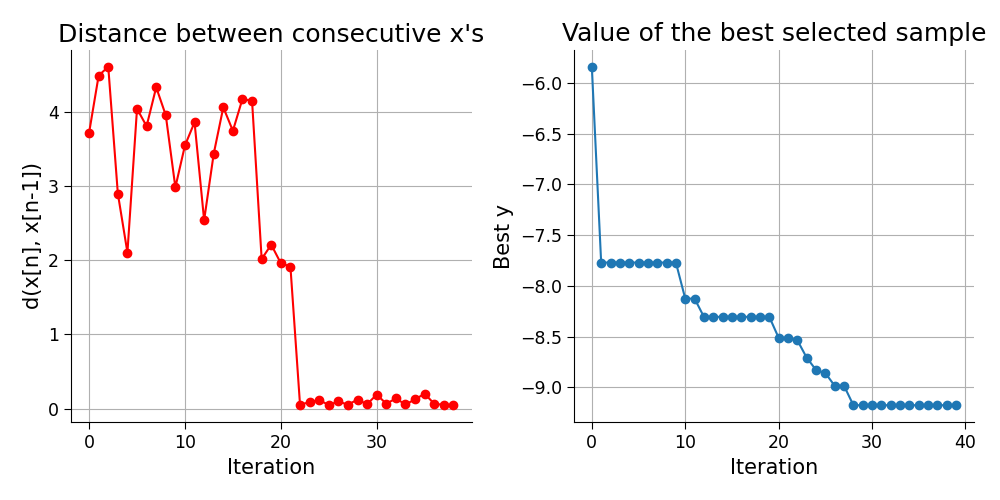

In [8]:
# try to get GPyOpt working

def convert_symmetry_to_weights(symmetry_params):
  # Initialize the weight matrix with zeros
  weights = np.zeros((4,12))
  symmetry_indices = {
    'Up':    [0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
    'Down':  [7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
    'Left':  [3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
    'Right': [3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}
  # Use the symmetry indices to populate the 48-dimensional weight vector
  for i, direction in enumerate(['Up', 'Down', 'Left', 'Right']):
    for j, idx in enumerate(symmetry_indices[direction]):
      weights[i, j] = symmetry_params[idx]
    return weights


def evaluate(W):
  game = GridworldGame(batch_size=256, n_rows=7, n_cols=7,
                     num_critters=1, num_food=10, lifetime=30,
                     rng=np.random.default_rng(48))
  # Run the game with the proposed weights
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


def objective_function_batch(X):
  results = []
  for x in X:
    weights = convert_symmetry_to_weights(x)
    score = evaluate(weights)
    results.append(-score)
  return np.array(results).reshape(-1, 1)

# Define the bounds of the search space
bounds = [{'name': 'var_'+str(i),
           'type': 'continuous',
           'domain': (-1,2)} for i in range(8)]

kernel = GPy.kern.RBF(input_dim=8, variance=2.0, lengthscale=0.5)
kernel.variance.fix()
kernel.lengthscale.fix()
# Create a Bayesian optimizer
optimizer = GPyOpt.methods.BayesianOptimization(f=objective_function_batch,
                                                domain=bounds,
                                                acquisition_type='MPI',
                                                kernel=kernel,
                                                initial_design_type='latin',  # Using Latin hypercube sampling
                                                initial_design_numdata=20)
# Update the acquisition function parameters for more exploration
#optimizer.acquisition.exploration_weight = 50

# Run optimization verbosely
max_iter = 20
for iteration in range(max_iter):
  optimizer.run_optimization(max_iter=1, verbosity=False)  # Run for one iteration
  print(f"\nIteration {iteration + 1}/{max_iter}:")
  print(f"  Cumulative Time: {optimizer.cum_time:.2f} seconds")
  print(f"  Current Best Parameters (x_opt): {optimizer.x_opt}")
  print(f"  Objective Value of Best Parameters (fx_opt): {optimizer.fx_opt:.4f}\n")
  print("-" * 50)

optimizer.plot_convergence()

This out of the box GP kind of sucks, appears to be getting caught in local minima. Bummer that the thing that should be robust, awesome, super cool is kind of fragile.

In [9]:
# try to get our own GP implementation going


def evaluate(W):
  game = GridworldGame(batch_size=256, n_rows=7, n_cols=7,
                     num_critters=1, num_food=10, lifetime=30,
                     rng=np.random.default_rng(48))
  # Run the game with the proposed weights
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


# Squared Exponential Kernel
def se_kernel(x, y, l=1.0, sigma_f=1.0):
  """Squared Exponential kernel."""
  sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
  return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

# Gaussian Process Posterior
def gp_posterior(X_train, Y_train, X_new, l=1.0, sigma_f=1.0, sigma_y=1e-8):
  """Compute the posterior mean and covariance for new data X_new given training data X_train and Y_train."""
  K = se_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
  K_s = se_kernel(X_train, X_new, l, sigma_f)
  K_ss = se_kernel(X_new, X_new, l, sigma_f) + 1e-8 * np.eye(len(X_new))
  K_inv = np.linalg.inv(K)
  # Posterior mean
  mu_s = K_s.T.dot(K_inv).dot(Y_train)
  # Posterior covariance
  cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
  return mu_s, cov_s

# Acquisition function: Expected Improvement (EI)
def expected_improvement(X_new, X_train, Y_train, l=1.0, sigma_f=1.0, xi=0.01):
  """Compute the expected improvement at X_new."""
  mu_s, cov_s = gp_posterior(X_train, Y_train, X_new, l, sigma_f)
  sigma_s = np.sqrt(np.diag(cov_s))
  mu_sample_opt = np.max(Y_train)
  with np.errstate(divide='warn'):
    imp = mu_s - mu_sample_opt - xi
    Z = imp / sigma_s
    ei = imp * norm.cdf(Z) + sigma_s * norm.pdf(Z)
    ei[sigma_s == 0.0] = 0.0
  return np.sum(ei)


def propose_next_sample(acquisition, X_train, Y_train, l=1.0, sigma_f=1.0, bounds=None, n_restarts=25):
  """Propose the next sampling point by optimizing the acquisition function.
  Args:
    acquisition: Acquisition function to optimize.
    X_train: Training inputs.
    Y_train: Training outputs.
    l, sigma_f: Hyperparameters for the kernel.
    bounds: Bounds on the inputs space.
    n_restarts: Number of restarts for the optimizer.
  Returns:
    x_next: The next sampling point.
  """
  dim = X_train.shape[1]
  min_val = 1
  x_next = None

  # Randomly sample possible starting points for optimizer
  starting_points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))

  for x_try in starting_points:
    res = minimize(lambda x: -acquisition(x.reshape(1, -1), X_train, Y_train, l, sigma_f),
                    x_try,
                    bounds=bounds,
                    method='L-BFGS-B')

    if res.fun < min_val:
      min_val = res.fun
      x_next = res.x

  return x_next.reshape(1, -1)

In [10]:
def gp_optimization(initial_params, n_iterations, bounds):
  """
  Use Gaussian Process to optimize the function evaluate by selecting the best parameters.

  Args:
  - initial_params: Initial parameters to start the optimization.
  - n_iterations: Number of iterations for the GP optimization.
  - bounds: Bounds for the parameters.

  Returns:
  - best_params: Best found parameters.
  - best_avg_score: Best average score.
  """

  # Initial data
  X_train = initial_params.reshape(1, -1)
  weights = convert_symmetry_to_weights(X_train[0])
  scores = evaluate(weights)
  Y_train = np.array([[np.mean(scores)]])  # Ensure Y_train is 2D
  #print(X_train)
  #print(Y_train)

  best_params = X_train[0]
  best_avg_score = Y_train[0, 0]

  for iteration in tqdm(range(n_iterations)):
    # Propose next sample
    X_new = propose_next_sample(expected_improvement, X_train, Y_train, bounds=bounds)
    #print(X_new)
    # Evaluate the new sample
    weights_new = convert_symmetry_to_weights(X_new[0])
    scores_new = evaluate(weights_new)
    avg_score_new = np.mean(scores_new)

    # Add new data to training set
    X_train = np.vstack((X_train, X_new))
    Y_train = np.vstack((Y_train, avg_score_new))

    # Update best parameters if needed
    if avg_score_new > best_avg_score:
      best_avg_score = avg_score_new
      best_params = X_new[0]
      print(f"Iteration {iteration + 1}:")
      print('Best params so far:', best_params)
      print('Best score so far:', best_avg_score)

  return best_params, best_avg_score

# Let's assume some bounds for your parameters. You might need to adjust these.
bounds = np.array([[-1, 2] for _ in range(8)])
# For simplicity, assuming all parameters are bounded between -1 and 2.

# Rerun the GP optimization
best_params_gp, best_avg_score_gp = gp_optimization(np.zeros(8),
                                                    n_iterations=50,
                                                    bounds=bounds)
best_params_gp, best_avg_score_gp

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3:
Best params so far: [ 1.07217391 -0.23500312  0.40579072 -0.20465745  0.25506982  0.05043894
  0.13312248  0.6101895 ]
Best score so far: 8.94921875
Iteration 9:
Best params so far: [ 0.80969902  0.25906457  0.4844684   0.07217125 -0.24919104  0.05599532
  0.39575875  0.31639002]
Best score so far: 9.296875
Iteration 10:
Best params so far: [ 1.7200086  -0.9272564   1.39393181 -0.43467426 -0.07484443 -0.38687142
  0.65614409  0.49084786]
Best score so far: 10.3125
Iteration 47:
Best params so far: [ 1.77063926 -0.82179823  1.5175359   0.18670765  0.32000468 -0.5333856
  0.09687149 -0.08982577]
Best score so far: 10.48828125


(array([ 1.77063926, -0.82179823,  1.5175359 ,  0.18670765,  0.32000468,
        -0.5333856 ,  0.09687149, -0.08982577]),
 10.48828125)

Our home brew version seems to be getting less stuck and running quicker than the GPyOpt, but still not as quick as simple propose and reject, note that the propose_next_sample bit takes up more and more time as the number of sample points get's better and better. Ideally for this kind of task, you'd be dropping points that weren't doing much and picking points based on how much info they give about where the true max is.

# MDP Notation
To get precise about what we are trying to optimize we first need to introduce some important notation, and formalize many of the general concepts introduced earlier in the book through our Gridworld example. If you are already farmiliar with these ideas feel free to skip this bit. Similarly if you find mathematical notation a bit overwhelming, you can also skim this section, (don't worry about understanding it all right away) and then use this as glossary as needed. A shortened version of these definitions also appear in the glossary/notation reference section found at the end of each notebook.

* $\pi_{\theta}(a|s)$: **Policy Function** - A policy is the behavioural blueprint for the organism. It's a function that takes (some representation or filtered down aspect of) the environmental state $s$ as input, and guided by its parameters $\theta$, gives the probability of taking action $a$, where $a$ is in the set $\mathcal{A}(s)$ of possible actions given state $s$. The organism can then sample an actio from this set according to these probabilities. Sometimes the explicit reference to $\theta$ is dropped when it is clear from context or does not need to be emphasized as in $\pi(a|s)$, other times the the reference to the parameters is made more explicit by writing $\pi(a | s, \theta)$. In our Gridworld example each of the organisms we defined, 'Random Valid', 'Parameterized Weights', 'Eat When Near' all had a policy function at their core.

* $s$: **A State** - The state represents a complete snapshot of what the environment looks like at a given moment. In our Gridworld example this is primarily the positions of food pieces and the organism, but also the number of rounds left in the simulation. The set of all possible states is denoted $\mathcal{S}$.

* $a$: **An Action** - The action an organism takes. Depending on how things are set up in our Gridworld example this might be represented as a direction or as a (row, columns) coordinate of the organism's new position, or as a flattened boolean index of the organism's new position. The set of all possible actions is denoted $\mathcal{A}$, and the set of possible actions in a given state as $\mathcal{A}(s)$.

* $r$ : **A Reward** - The immediate reward (feedback, score, points etc.) an organism recieves after taking an action $a$ in state $s$ and transitioning to new state $s'$. In our Gridworld example $r = 1$ if the organism eats a food piece as a result of its move and $r = 0$ otherwise.

* $\theta$: **Parameters** - The aspects of an organism's policy function that can be represented by numbers. Note that these do not describe the overall structure of the policy function, but rather determine a particular instance of the policy functions possible *given* the structure (archietecture) of a policy function. In our 'Parameterized Weights' policy from our Gridworld example, the connective weight strengths $W$ are the paramweters, i.e. $\theta = W$ in for this particular policy. For a more complicated policy with many layers of connective weights we might write $\theta = \{W_1, W_2,\dots, W_N \}$. We use $\theta$ as a generic term so that we can make general statements about parameterized policies without having to worry about the particular archiectecure or functional form of the policy.   

Given the stochastic nature of the environment (and often the policy as well), at any given time $t$ over the course of a simulation run, each of states, actions and rewards can be thought of as random variables specifically:

* $S_t$: **State at Time $t$** - A random variable that denotes the state of the environment at a specific time $t$. For example, $S_t = s$ means that at time $t$, in a particular simulation run, the environment was in state $s$, or in other words that $s$ is the realization of the random variable $S_t$.

* $A_t$: **Action at Time $t$** - A random variable denoting the action taken by the organism at time $t$. $A_t = a$ indicates that the action $a$ is taken at time $t$, or that $a$ is the realization of the random variable $A_t$ in a particular simulation run.

* $R_t$: **Reward at Time $t$** - A random variable indicating the immediate reward received by the organism at time $t$. $R_t = r$ indicates that the reward $r$ is obtained at time $t$, or in that $r$ is the realization of the random variable $R_t$ in a particular simulation run.

* $T$: **Total Simulation Time** - The total number of time steps in a given simulation. There are cases where having an infinite time horizon, $T=\infty$, is a mathematical convenience, but since our focus is on evolved, living and learning systems, and few things live forever, we will typically work with a finite time horizons.

* $t$: **Time-Step Index** - We typically subscript with $t$ to denote the value of a state, reward, action, etc. at a given specific time $t$.

We can then think of simulation run as sequence of random variables:
$$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \dots, S_{T-1}, A_{T-1}, R_{T}, {S_T}$$

The dynamics, or equations of motion, that generate this sequence of random variables are primarily encapsulated in a *transition function*, together with an *initial state distribution*, both defined as follows.

* $p(s', r | s, a)$: **Transition Function** - Sometimes called the *State Transition Function*, or the *Transition Kernel* (kernel is more common when dealing with continuous state spaces) this function give the probability of transitioning from state $s$ to $s'$ and recieving reward $r$ from time-step $t$ to $t+1$, given that action $a$ is taken at time $t$. In terms of our previous notation this is defined as:
$$ p(s', r | s, a) := \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, A_t = a \}$$  

* $p_0(s)$: **Initial State Distribution** - This is the probability distribution (density function) over the set of possible states, \mathcal{S}, so $p_0(s) := \Pr \{S_0 = s\}$. Sometimes we write $S_0 \sim p_0$, which is read as 'The random variable $S_0$ is distributed according to the probability density function $p_0$'.

This random variable notation also allows us to make uur definition of a policy function more precise: $$\pi_{\theta}(a | s) := \Pr \{A_{t} = a | S_t = s\}.$$

Then, if a policy is fixed it can simply be folded into the dynamics of the environment, creating what is refered to as the *policy-induced dynamics*.

* $p_\pi(s', r | s)$: **Policy-Induced Dynamics** - This is also called the 'dynamics under policy $\pi$ and is defined as:
$$p_\pi(s', r | s)$:= \Pr \{S_{t+1} = s' , R_{t+1} = r | S_t = s, \pi \} = \sum_{a\in\mathcal{A}(s)} \pi_\theta (a | s) \ p(s', r | s, a).$$
Sometimes the depedence on a specfic policy, $\pi$, is taken as implicit and we simply write $p(s', r | s)$.

The takeaway here is that for a fixed $\pi$ and a given transition function $p$ (and initial state distribution $p_0$) the stochastic dynamics of the system are completely determined.

With all that defined we can start to formally describe how rewards should be added up over time to define our goals. We just need to introduce the idea of a *Return* and a *Value* function.

* $G_t$: **Return following time $t$** - Sometimes called the reward to go, or simply the return, this a random variable that indicates the total reward yet to be realized after time $t$, i.e. $G_t := \sum_{k=t+1}^T R_k$.

* $v_{\pi}(s,t)$: **Value Function** - A function giving the *expected* return conditional on being in state $s$ at time $t$ and following a given policy $\pi$, specifically:
$$v_{\pi}(s,t) := \mathbb{E}_\pi \left[G_t | S_t = s \right].$$
In a slight stretch of notation $t$ can be treated as part of $s$ and we can write $v_{\pi}(s)$. The dependence on a specific policy is sometimes treated as implicit and we write $v(s)$ or $v(s,t)$.

In this context then our goal is to maximize the *Expectation* of a simulation run, or equivalently the average value from playing through many simulations (in the limit as many --> $\infty$). We call this formalization of our goal objective function and define our particular objective function in this context as

* $J(\theta)$: **Objective Function** - The function that we are trying to maximize, emphasizing the dependence on the parameters, $\theta$.

The objective function is in some ways the most subjective thing in this whole set up. It's what defines the "problem to be solved". In our particular case we we are going to use the following as our objective.

$$J(\theta):= \mathbb{E}\left[ v_{\pi_\theta}(S_0) \right] = \sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

Then the formalization of our problem is choosing parameters $\theta$ such that $J(\theta)$ is as high as possible. In general this goal is written as:
$$ \max_{\theta} J(\theta),$$

and in our particular case of maximizing the expected value, given a finite and discrete state space, our goal is written as:

$$ \max_\theta\sum_{s \in \mathcal{S}} p_0(s) \cdot v_{\pi_{\theta}}(s)$$

Let's get formal and introduce some notation. Our policy can be thought of as a function $\pi(x|\theta)$ which takes some environmental input $x$, and using its parameters $\theta$, it returns probabilites over the set of possible actions(and a sample of the actions according to those probabilites). We use $s$ to represent the *state* of the board, specifically the locations of the food and the organism, and $s_t$ to indicate the state at a particular time step *t* in the simulation. $R_t$ is the reward at time-step $t$, in our Gridworld this will be a $R_t=1$ if the organism eats food at time-step $t$ and $R_t=0$ if it does not.